In [10]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Float
from sqlalchemy.orm import sessionmaker, relationship, declarative_base
from langchain_core.runnables.config import RunnableConfig


load_dotenv()

DATABASE_URL = os.getenv("DATABASE_URL", "sqlite:///example.db")
engine = create_engine(DATABASE_URL)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

Base = declarative_base()

# Definition of the Users table
class User(Base):
    __tablename__ = "users"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, index=True)
    age = Column(Integer)
    email = Column(String, unique=True, index=True)

    orders = relationship("Order", back_populates="user")

# Definition of the Food table
class Food(Base):
    __tablename__ = "food"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, unique=True, index=True)
    price = Column(Float)

    orders = relationship("Order", back_populates="food")

# Definition of the Orders table
class Order(Base):
    __tablename__ = "orders"

    id = Column(Integer, primary_key=True, index=True)
    food_id = Column(Integer, ForeignKey("food.id"))
    user_id = Column(Integer, ForeignKey("users.id"))

    user = relationship("User", back_populates="orders")
    food = relationship("Food", back_populates="orders")

In [11]:
# sql_agent.py

import os
from dotenv import load_dotenv
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sqlalchemy import text, inspect
from langgraph.graph import StateGraph, END

class AgentState(TypedDict):
    question: str
    sql_query: str
    query_result: str
    query_rows: list
    current_user: str
    attempts: int
    relevance: str
    sql_error: bool

def get_database_schema(engine):
    inspector = inspect(engine)
    schema = ""
    for table_name in inspector.get_table_names():
        schema += f"Table: {table_name}\n"
        for column in inspector.get_columns(table_name):
            col_name = column["name"]
            col_type = str(column["type"])
            if column.get("primary_key"):
                col_type += ", Primary Key"
            if column.get("foreign_keys"):
                fk = list(column["foreign_keys"])[0]
                col_type += f", Foreign Key to {fk.column.table.name}.{fk.column.name}"
            schema += f"- {col_name}: {col_type}\n"
        schema += "\n"
    print("Retrieved database schema.")
    return schema

class GetCurrentUser(BaseModel):
    current_user: str = Field(
        description="The name of the current user based on the provided user ID."
    )

def get_current_user(state: AgentState, config: RunnableConfig):
    print("Retrieving the current user based on user ID.")
    user_id = config["configurable"].get("current_user_id", None)
    if not user_id:
        state["current_user"] = "User not found"
        print("No user ID provided in the configuration.")
        return state

    session = SessionLocal()
    try:
        user = session.query(User).filter(User.id == int(user_id)).first()
        if user:
            state["current_user"] = user.name
            print(f"Current user set to: {state['current_user']}")
        else:
            state["current_user"] = "User not found"
            print("User not found in the database.")
    except Exception as e:
        state["current_user"] = "Error retrieving user"
        print(f"Error retrieving user: {str(e)}")
    finally:
        session.close()
    return state

class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

def check_relevance(state: AgentState, config: RunnableConfig):
    question = state["question"]
    schema = get_database_schema(engine)
    print(f"Checking relevance of the question: {question}")
    system = """You are an assistant that determines whether a given question is related to the following database schema.

Schema:
{schema}

Respond with only "relevant" or "not_relevant".
""".format(schema=schema)
    human = f"Question: {question}"
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )
    llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(CheckRelevance)
    relevance_checker = check_prompt | structured_llm
    relevance = relevance_checker.invoke({})
    state["relevance"] = relevance.relevance
    print(f"Relevance determined: {state['relevance']}")
    return state

class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the user's natural language question."
    )

def convert_nl_to_sql(state: AgentState, config: RunnableConfig):
    question = state["question"]
    current_user = state["current_user"]
    schema = get_database_schema(engine)
    print(f"Converting question to SQL for user '{current_user}': {question}")
    system = """You are an assistant that converts natural language questions into SQL queries based on the following schema:

{schema}

The current user is '{current_user}'. Ensure that all query-related data is scoped to this user.

Provide only the SQL query without any explanations. Alias columns appropriately to match the expected keys in the result.

For example, alias 'food.name' as 'food_name' and 'food.price' as 'price'.
""".format(schema=schema, current_user=current_user)
    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}"),
        ]
    )
    llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(ConvertToSQL)
    sql_generator = convert_prompt | structured_llm
    result = sql_generator.invoke({"question": question})
    state["sql_query"] = result.sql_query
    print(f"Generated SQL query: {state['sql_query']}")
    return state

def execute_sql(state: AgentState):
    sql_query = state["sql_query"].strip()
    session = SessionLocal()
    print(f"Executing SQL query: {sql_query}")
    try:
        result = session.execute(text(sql_query))
        if sql_query.lower().startswith("select"):
            rows = result.fetchall()
            columns = result.keys()
            if rows:
                header = ", ".join(columns)
                state["query_rows"] = [dict(zip(columns, row)) for row in rows]
                print(f"Raw SQL Query Result: {state['query_rows']}")
                # Format the result for readability
                data = "; ".join([f"{row.get('food_name', row.get('name'))} for ${row.get('price', row.get('food_price'))}" for row in state["query_rows"]])
                formatted_result = f"{header}\n{data}"
            else:
                state["query_rows"] = []
                formatted_result = "No results found."
            state["query_result"] = formatted_result
            state["sql_error"] = False
            print("SQL SELECT query executed successfully.")
        else:
            session.commit()
            state["query_result"] = "The action has been successfully completed."
            state["sql_error"] = False
            print("SQL command executed successfully.")
    except Exception as e:
        state["query_result"] = f"Error executing SQL query: {str(e)}"
        state["sql_error"] = True
        print(f"Error executing SQL query: {str(e)}")
    finally:
        session.close()
    return state

def generate_human_readable_answer(state: AgentState):
    sql = state["sql_query"]
    result = state["query_result"]
    current_user = state["current_user"]
    query_rows = state.get("query_rows", [])
    sql_error = state.get("sql_error", False)
    print("Generating a human-readable answer.")
    system = """You are an assistant that converts SQL query results into clear, natural language responses without including any identifiers like order IDs. Start the response with a friendly greeting that includes the user's name.
    """
    if sql_error:
        # Directly relay the error message
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable error message in a single sentence, starting with 'Hello {current_user},' informing them about the issue."""
                ),
            ]
        )
    elif sql.lower().startswith("select"):
        if not query_rows:
            # Handle cases with no orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable answer to the original question in a single sentence, starting with 'Hello {current_user},' and mention that there are no orders found."""
                    ),
                ]
            )
        else:
            # Handle displaying orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable answer to the original question in a single sentence, starting with 'Hello {current_user},' and list each item ordered along with its price. For example: 'Hello Bob, you have ordered Lasagne for $14.0 and Spaghetti Carbonara for $15.0.'"""
                    ),
                ]
            )
    else:
        # Handle non-select queries
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable confirmation message in a single sentence, starting with 'Hello {current_user},' confirming that your request has been successfully processed."""
                ),
            ]
        )

    llm = ChatOpenAI(temperature=0)
    human_response = generate_prompt | llm | StrOutputParser()
    answer = human_response.invoke({})
    state["query_result"] = answer
    print("Generated human-readable answer.")
    return state

class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")

def regenerate_query(state: AgentState):
    question = state["question"]
    print("Regenerating the SQL query by rewriting the question.")
    system = """You are an assistant that reformulates an original question to enable more precise SQL queries. Ensure that all necessary details, such as table joins, are preserved to retrieve complete and accurate data.
    """
    rewrite_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                f"Original Question: {question}\nReformulate the question to enable more precise SQL queries, ensuring all necessary details are preserved.",
            ),
        ]
    )
    llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(RewrittenQuestion)
    rewriter = rewrite_prompt | structured_llm
    rewritten = rewriter.invoke({})
    state["question"] = rewritten.question
    state["attempts"] += 1
    print(f"Rewritten question: {state['question']}")
    return state

def generate_funny_response(state: AgentState):
    print("Generating a funny response for an unrelated question.")
    system = """You are a charming and funny assistant who responds in a playful manner.
    """
    human_message = "I can not help with that, but doesn't asking questions make you hungry? You can always order something delicious."
    funny_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human_message),
        ]
    )
    llm = ChatOpenAI(temperature=0.7)
    funny_response = funny_prompt | llm | StrOutputParser()
    message = funny_response.invoke({})
    state["query_result"] = message
    print("Generated funny response.")
    return state

def end_max_iterations(state: AgentState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state

def relevance_router(state: AgentState):
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "generate_funny_response"

def check_attempts_router(state: AgentState):
    if state["attempts"] < 3:
        return "convert_to_sql"
    else:
        return "end_max_iterations"

def execute_sql_router(state: AgentState):
    if not state.get("sql_error", False):
        return "generate_human_readable_answer"
    else:
        return "regenerate_query"

workflow = StateGraph(AgentState)

workflow.add_node("get_current_user", get_current_user)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("convert_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("generate_human_readable_answer", generate_human_readable_answer)
workflow.add_node("regenerate_query", regenerate_query)
workflow.add_node("generate_funny_response", generate_funny_response)
workflow.add_node("end_max_iterations", end_max_iterations)

workflow.add_edge("get_current_user", "check_relevance")

workflow.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "convert_to_sql": "convert_to_sql",
        "generate_funny_response": "generate_funny_response",
    },
)

workflow.add_edge("convert_to_sql", "execute_sql")

workflow.add_conditional_edges(
    "execute_sql",
    execute_sql_router,
    {
        "generate_human_readable_answer": "generate_human_readable_answer",
        "regenerate_query": "regenerate_query",
    },
)

workflow.add_conditional_edges(
    "regenerate_query",
    check_attempts_router,
    {
        "convert_to_sql": "convert_to_sql",
        "max_iterations": "end_max_iterations",
    },
)

workflow.add_edge("generate_human_readable_answer", END)
workflow.add_edge("generate_funny_response", END)
workflow.add_edge("end_max_iterations", END)

workflow.set_entry_point("get_current_user")

app = workflow.compile()


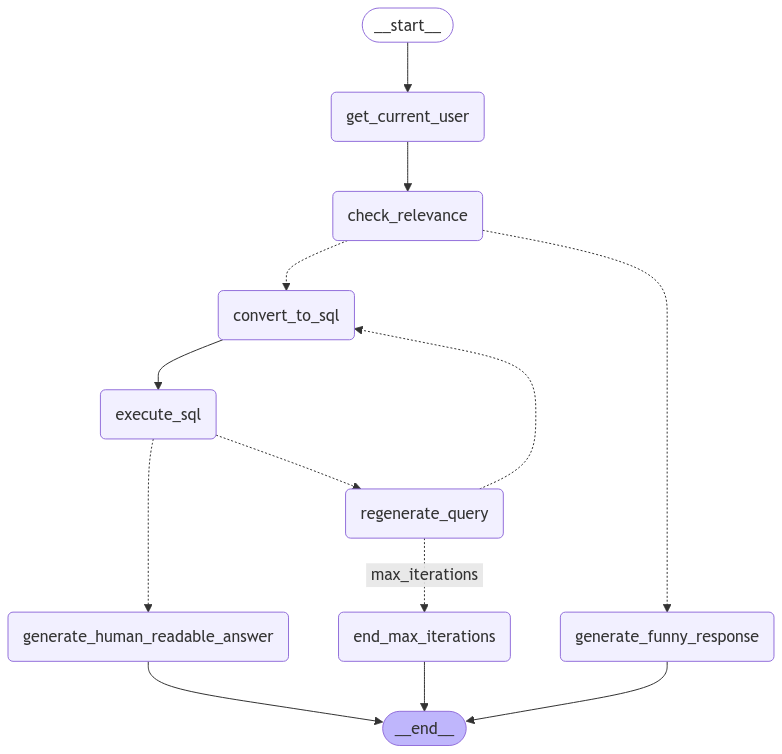

In [7]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [8]:
fake_config = {"configurable": {"current_user_id": "2"}}

In [14]:
user_question_1 = "Get me all the orders."
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])

Retrieving the current user based on user ID.
Current user set to: Bob
Retrieved database schema.
Checking relevance of the question: Get me all the orders.
Relevance determined: relevant
Retrieved database schema.
Converting question to SQL for user 'Bob': Get me all the orders.
Generated SQL query: SELECT orders.id AS order_id, food.name AS food_name, food.price AS price, users.name AS user_name FROM orders JOIN food ON orders.food_id = food.id JOIN users ON orders.user_id = users.id WHERE users.name = 'Bob'
Executing SQL query: SELECT orders.id AS order_id, food.name AS food_name, food.price AS price, users.name AS user_name FROM orders JOIN food ON orders.food_id = food.id JOIN users ON orders.user_id = users.id WHERE users.name = 'Bob'
Raw SQL Query Result: [{'order_id': 3, 'food_name': 'Lasagne', 'price': 14.0, 'user_name': 'Bob'}, {'order_id': 4, 'food_name': 'Spaghetti Carbonara', 'price': 15.0, 'user_name': 'Bob'}]
SQL SELECT query executed successfully.
Generating a human-rea

In [13]:
def get_orders_for_user(user_id: int):
    session = SessionLocal()
    try:
        orders = (
            session.query(Order)
            .join(Food, Order.food_id == Food.id)
            .filter(Order.user_id == user_id)
            .all()
        )
        if not orders:
            print(f"No orders found for user_id {user_id}.")
            return []

        order_list = []
        for order in orders:
            order_info = {
                "order_id": order.id,
                "food_name": order.food.name,
                "price": order.food.price
            }
            order_list.append(order_info)

        return order_list
    except Exception as e:
        print(f"Error retrieving orders for user_id {user_id}: {e}")
        return []
    finally:
        session.close()

orders = get_orders_for_user(2)
orders

[{'order_id': 3, 'food_name': 'Lasagne', 'price': 14.0},
 {'order_id': 4, 'food_name': 'Spaghetti Carbonara', 'price': 15.0}]

In [ ]:
user_question_2 = "Tell me a joke."
result_2 = app.invoke({"question": user_question_2, "attempts": 0}, config=fake_config)
print("Result:", result_2["query_result"])

In [ ]:
user_question_3 = "Show me my orders"
result_3 = app.invoke({"question": user_question_3, "attempts": 0}, config=fake_config)
print("Result:", result_3["query_result"])